In [54]:
import warnings
warnings.filterwarnings('ignore')import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [2]:
path  = 'D:/Google Drive/Citadale Datathon/2018 Datathon Materials/'
chemicals = pd.read_csv(path + 'main data/chemicals.csv')
chemicals = chemicals[chemicals['year'] >= 2010]

In [3]:
health_data ={}

for i in glob.glob(path + "health data/*"):
    year = i.split('\\')[-1].split()[0]
    state = i.split('\\')[-1].split('County Health Ranking')[1].split(' Data')[0]
    try:
        if year not in health_data:
            health_data[year] = pd.read_excel(i , sheet_name='Measure Data', skiprows=1)
        else:
            health_data[year] = pd.concat([health_data[year], 
                                           pd.read_excel(i , sheet_name='Measure Data', skiprows=1)], sort=False)
    except:
        if year not in health_data:
            health_data[year] = pd.read_excel(i , sheet_name='Ranked Measure Data', skiprows=1)
        else:
            health_data[year] = pd.concat([health_data[year], 
                                           pd.read_excel(i , sheet_name='Ranked Measure Data', skiprows=1)], sort=False)
    
    health_data[year].dropna(how = 'all', inplace = True)
    health_data[year]['Year'] = year
    health_data[year] = health_data[year][['Year', 'FIPS', 'State', 'County', 'Population', '% Fair/Poor', ]]

In [4]:
health_df = pd.concat(health_data.values())
health_df = health_df[pd.notnull(health_df['County'])]
health_df['Total Unhealthy'] = health_df['Population'] * health_df['% Fair/Poor']/100

In [53]:
health_df_grouped = health_df.groupby('County').sum()
health_df_grouped['% Fair/Poor'] = health_df_grouped['Total Unhealthy']/ health_df_grouped['Population']

In [6]:
health_df_grouped = health_df_grouped.join(health_data['2010'][['State','County']].set_index('County'))
health_df_grouped = health_df_grouped.sort_values(by = '% Fair/Poor', ascending=False)

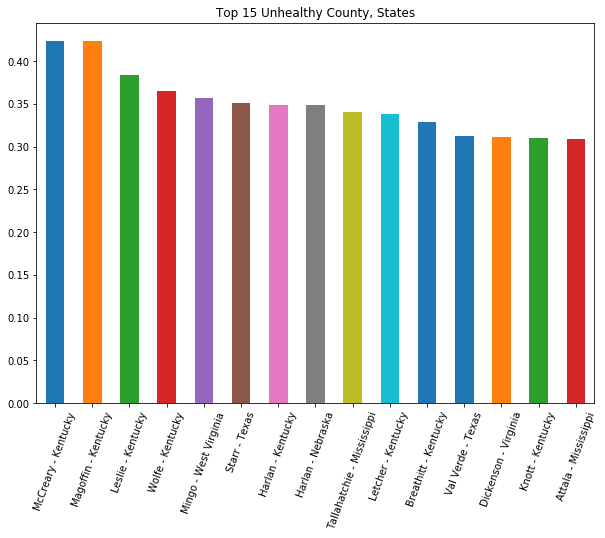

In [7]:
health_df_grouped.index = health_df_grouped.reset_index()['County'] + ' - ' + health_df_grouped.reset_index()['State']
health_df_grouped = health_df_grouped[pd.notnull(health_df_grouped.index)]
health_df_grouped.head(15)['% Fair/Poor'].plot(kind = 'bar', figsize = (10, 7), title = 'Top 15 Unhealthy County, States')
plt.xticks(rotation = 70)
plt.show()

In [8]:
health_df_grouped_state = health_df.groupby('State').sum()
health_df_grouped_state['% Fair/Poor'] = health_df_grouped_state['Total Unhealthy']/ health_df_grouped_state['Population']

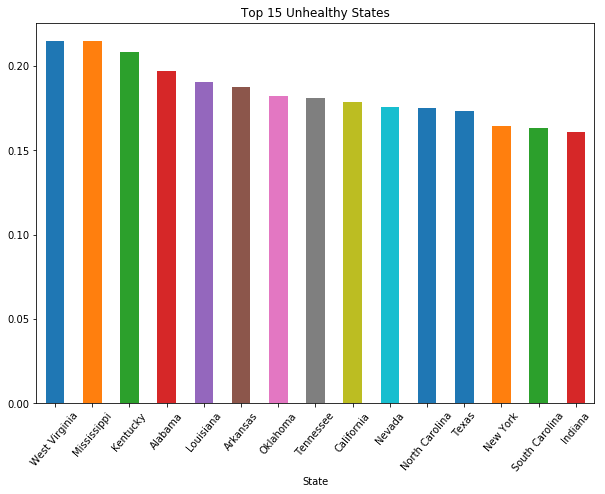

In [9]:
health_df_grouped_state = health_df_grouped_state.sort_values(by = '% Fair/Poor', ascending=False)
health_df_grouped_state = health_df_grouped_state[pd.notnull(health_df_grouped_state.index)]
health_df_grouped_state.head(15)['% Fair/Poor'].plot(kind = 'bar', figsize = (10, 7), title = 'Top 15 Unhealthy States')
plt.xticks(rotation = 50)
plt.show()

In [24]:
wm = lambda x: np.average(x, weights = chemicals.loc[x.index, "pop_served"])
f = {'pop_served': 'sum', 'value': {'weighted_mean' : wm} }
chemicals_expose = chemicals.groupby(['year', 'fips', 'chemical_species']).agg(f)

In [25]:
chemicals_expose  = (chemicals_expose.reset_index().set_index('fips')
                     .join(health_data['2010'][['State','County', 'FIPS']].set_index('FIPS')))
chemicals_expose.columns = ['year','chemical_species','pop_served_sum','value_weighted_mean','State','County']

In [26]:
chemicals_expose_pivot = chemicals_expose.reset_index().pivot_table(values = 'value_weighted_mean', index = ['year', 'index'],
                                           columns = 'chemical_species').fillna(0).reset_index()

In [27]:
health_df[['Year','FIPS']] = health_df[['Year','FIPS']].apply(pd.to_numeric)
chemicals_expose_pivot[['year', 'index']] = chemicals_expose_pivot[['year', 'index']].apply(pd.to_numeric)

In [138]:
chemicals_expose_pivot.rename(columns=dict(zip(['year', 'index'], ['Year','FIPS'])), inplace=True)
health_df2 = health_df.set_index(['Year','FIPS']).join(chemicals_expose_pivot.set_index(['Year','FIPS']), how='inner')
health_df2.dropna(inplace = True)

In [139]:
X = health_df2.drop(columns = ['County', '% Fair/Poor', 'Total Unhealthy', 'State'])
y = health_df2['% Fair/Poor']


In [140]:
health_df.to_csv('County Health %.csv')

Correlation Matrix

In [145]:
X.drop(columns='Population').columns

Index(['Arsenic', 'DEHP', 'Halo-Acetic Acid', 'Nitrates', 'Trihalomethane',
       'Uranium'],
      dtype='object')

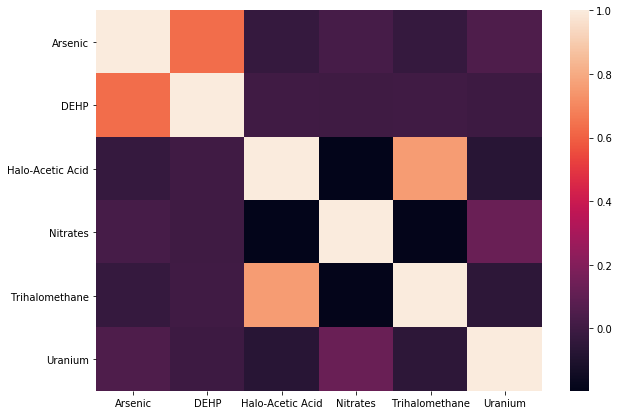

In [144]:
plt.figure(figsize = (10, 7))
sns.heatmap(X.drop(columns='Population').corr(),
            xticklabels=X.drop(columns='Population').corr().columns.values,
            yticklabels=X.drop(columns='Population').corr().columns.values)
plt.show()

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) # make the predictions by the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            % Fair/Poor   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2345.
Date:                Sat, 20 Oct 2018   Prob (F-statistic):               0.00
Time:                        13:33:34   Log-Likelihood:                -26166.
No. Observations:                7132   AIC:                         5.235e+04
Df Residuals:                    7125   BIC:                         5.239e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Population        4.327e-06    4.7e-07      9.202      0.000    3.41e-06    5.25e-06
Arsenic              0.2475      0.028      8.691      0.000       0.192       0.303
DEHP                -0.1186      0.021     -5.558      0.000      -0.160      -0.077
Halo-Acetic Acid     0.1076      0.011      9.550      0.000       0.086       0.130
Nitrates             2.3981      0.081     29.727      0.000       2.240       2.556
Trihalomethane       0.2906      0.007     38.925      0.000       0.276       0.305
Uranium              0.1301      0.026      5.015      0.000       0.079       0.181
==============================================================================
Omnibus:                      407.566   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1413.876
Skew:                          -0.203   Prob(JB):                    9.56e-308
Kurtosis:                       5.143   Cond. No.                     1.76e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
health_df2_state = pd.get_dummies(health_df2, columns = ['State'])
X = health_df2_state.drop(columns = ['County', '% Fair/Poor', 'Total Unhealthy'])
y = health_df2['% Fair/Poor']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) # make the predictions by the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            % Fair/Poor   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     203.1
Date:                Sat, 20 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:26:10   Log-Likelihood:                -20377.
No. Observations:                7132   AIC:                         4.082e+04
Df Residuals:                    7099   BIC:                         4.105e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Population           -7.532e-07   2.23e-07     -3.380      0.001   -1.19e-06   -3.16e-07
Arsenic                 -0.0114      0.013     -0.872      0.383      -0.037       0.014
DEHP                     0.0057      0.010      0.594      0.552      -0.013       0.024
Halo-Acetic Acid         0.0093      0.005      1.748      0.080      -0.001       0.020
Nitrates                -0.2957      0.049     -6.084      0.000      -0.391      -0.200
Trihalomethane           0.0020      0.004      0.492      0.623      -0.006       0.010
Uranium                  0.0053      0.012      0.444      0.657      -0.018       0.029
State_California        18.0043      0.300     60.025      0.000      17.416      18.592
State_Colorado          13.1947      0.268     49.219      0.000      12.669      13.720
State_Connecticut       10.8988      0.649     16.801      0.000       9.627      12.170
State_Florida           18.1307      0.253     71.723      0.000      17.635      18.626
State_Iowa              12.1530      0.217     56.018      0.000      11.728      12.578
State_Kansas            14.0427      0.251     55.957      0.000      13.551      14.535
State_Kentucky          24.2751      0.227    107.124      0.000      23.831      24.719
State_Louisiana         20.9012      0.261     80.173      0.000      20.390      21.412
State_Maine             13.6993      0.464     29.524      0.000      12.790      14.609
State_Maryland          14.0155      0.409     34.285      0.000      13.214      14.817
State_Massachusetts     11.7794      0.520     22.665      0.000      10.761      12.798
State_Michigan          14.5927      0.295     49.550      0.000      14.015      15.170
State_Minnesota         11.4848      0.218     52.588      0.000      11.057      11.913
State_Missouri          18.2873      0.193     94.824      0.000      17.909      18.665
State_New Hampshire     12.1820      0.596     20.430      0.000      11.013      13.351
State_New Jersey        15.7049      0.402     39.042      0.000      14.916      16.493
State_New York          13.9030      0.266     52.310      0.000      13.382      14.424
State_North Carolina    20.1069      0.247     81.258      0.000      19.622      20.592
State_Oregon            15.1682      0.316     48.044      0.000      14.549      15.787
State_Pennsylvania      15.1880      0.250     60.726      0.000      14.698      15.678
State_South Carolina    18.8782      0.293     64.528      0.000      18.305      19.452
State_Utah              13.0660      0.352     37.170      0.000      12.377      13.755
State_Vermont           11.5271      0.461     25.015      0.000      10.624      12.430
State_Washington        15.7386      0.295     53.280      0.000      15.160      16.318
State_West Virginia     22.1569      0.271     81.781    

Kentucky and Mississipi

In [66]:
chemicals_expose_pivot_st = chemicals_expose.reset_index().pivot_table(values = 'value_weighted_mean', 
                                                                       index = ['year', 'index', 'State'],
                                           columns = 'chemical_species').fillna(0).reset_index()

In [75]:
chemicals_expose_pivot_st_sum = chemicals_expose_pivot_st.groupby(['State']).sum()
chemicals_expose_pivot_st_sum['Total'] = chemicals_expose_pivot_st_sum.iloc[:, -6:].sum(axis = 1)
chemicals_expose_pivot_st_pct = chemicals_expose_pivot_st_sum.iloc[:, -7:-1].apply(lambda x: 
                                                                                 x/chemicals_expose_pivot_st_sum['Total'])

In [87]:
selected_states = chemicals_expose_pivot_st_pct.loc[['Kentucky', 'West Virginia']].T

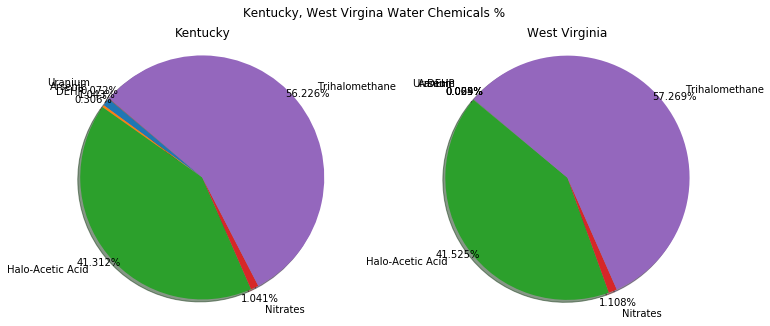

In [106]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
f.suptitle('Kentucky, West Virgina Water Chemicals %')
labels = list(selected_states.index)
sizes_ax1 = list(selected_states['Kentucky'])
sizes_ax2 = list(selected_states['West Virginia'])
colors = ['yellowgreen', 'gold', 'lightcoral']
ax1.pie(sizes_ax1, labels=labels, #colors=colors,
        autopct='%1.3f%%', shadow=True, startangle=140, pctdistance = 1.1, labeldistance = 1.2)
ax1.axis('equal')
ax1.set_title('Kentucky')

ax2.pie(sizes_ax2, labels=labels, #colors=colors,
        autopct='%1.3f%%', shadow=True, startangle=140, pctdistance = 1.1, labeldistance = 1.2)
ax2.axis('equal')
ax2.set_title('West Virginia')
plt.show()

Kentucky Health Trend

In [112]:
state_health_trend = health_df.groupby(['State','Year']).sum()
state_health_trend['% Fair/Poor'] = state_health_trend['Total Unhealthy']/state_health_trend['Population']

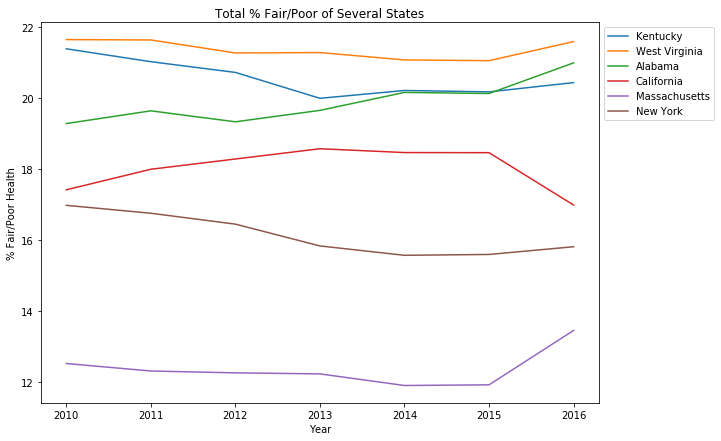

In [133]:
plt.figure(figsize = (10, 7))
states = ['Kentucky', 'West Virginia', 'Alabama', 'California', 'Massachusetts', "New York"]
state_health_trend_selected = state_health_trend.loc[states]
for i in states:
    (state_health_trend_selected.loc[i]['% Fair/Poor']*100).plot(label = i)

plt.ylabel('% Fair/Poor Health')
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Total % Fair/Poor of Several States")
plt.show()